In this notebook, I will estimate the effect of monetary policy shocks on inflation, industrial production, and real effective exchange rate. I will use the following Local projection model. 


**Eq1:**
\begin{align*}
\pi_{c,t+h} = \sum_{j=1}^J \alpha_j^h \pi_{c,t-j}  + \sum_{k=1}^K \beta_k^h i_{c,t-k}+ \text{FEs (country, time)}
\end{align*}


**Eq2:**
\begin{align*}
\text{IP}_{c,t+h} = \sum_{j=1}^J \alpha_j^h \text{IP}_{c,t-j}  + \sum_{k=1}^K \beta_k^h i_{c,t-k}+ \text{FEs (country, time)}
\end{align*}

**Eq3:**
\begin{align*}
REER_{c,t+h} = \sum_{j=1}^J \alpha_j^h REER_{c,t-j}  + \sum_{k=1}^K \beta_k^h i_{c,t-k}+ \text{FEs (country, time)}
\end{align*}

where $i_{c,t}$ is the policy rate, $\pi_{c,t}$ is the inflation rate, $\text{IP}_{c,t}$ is the industrial production growth, $\text{REER}_{c,t}$ is the change in real effective exchange rate, and $h$ is the horizon.

In [6]:
// Set more
set more off

* * * * * * * Navigating to the folder
global folder "/Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empirics"
cd "$folder"

// Loading data
use "./data/panel_df_tr2.dta", clear
describe




/Users/suraj/Library/CloudStorage/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empi
> rics



Contains data from ./data/panel_df_tr2.dta
  obs:         3,285                          
 vars:            18                          29 Jan 2023 15:30
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
country_code    str3    %-9s                  
date            double  %td                   
pconv           double  %10.0g                
srr             double  %10.0g                
cpi             double  %10.0g                
usdex           double  %10.0g                
neer            double  %10.0g                
reer            double  %10.0g                
dumL1           double  %10.0g                
dumH1           double  %10.0g                
dumL2           do

In [7]:
* Choose impulse reponse horizon for macro variables such as cpi, reer, and ip. These macro variables are already in log terms
local hmax = 24
foreach x in cpi reer ip{
    forvalue h = 0/`hmax'{
        qui gen `x'_yoy_`h' = f`h'.`x'-l12.f`h'.`x'
    }
    * Creating simple inflation variable also apart from the subscripts 
    qui gen `x'_yoy = `x'-l12.`x'
}

In [8]:
// Specifying options for local projection regression 
local ar = 12
local ma = 12

In [9]:
* Running sxr inflation on lags of Food and ip Inflation
eststo clear
qui cap drop horizons Zero b_cpi_srr u_cpi_srr d_cpi_srr b_ip_srr u_ip_srr d_ip_srr b_reer_srr u_reer_srr d_reer_srr

* Initializing variables to store the regression output
qui gen horizons = _n-1 if _n <= `hmax'
qui gen Zero = 0 if _n <= `hmax'
qui gen b_cpi_srr = .
qui gen u_cpi_srr = .
qui gen d_cpi_srr = .
qui gen b_ip_srr = .
qui gen u_ip_srr = .
qui gen d_ip_srr = .
qui gen b_reer_srr = .
qui gen u_reer_srr = .
qui gen d_reer_srr = .

forv h = 0/`hmax'{
    
    ** Regression 1
    * on inflation
    qui reghdfe cpi_yoy_`h' l(0/`ma').srr l(1/`ar').cpi_yoy , absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the Food Coefficient results
    qui replace b_cpi_srr = _b[srr]  if _n == `h'+1
    qui replace u_cpi_srr = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_cpi_srr = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
}

forv h = 0/`hmax'{
    ** Regression 2
    * on ip
    qui reghdfe ip_yoy_`h' l(0/`ma').srr l(1/`ar').ip_yoy, absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the ip Coefficient Reults
    qui replace b_ip_srr = _b[srr]  if _n == `h'+1
    qui replace u_ip_srr = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_ip_srr = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
}

forv h = 0/`hmax'{
    ** Regression 3
    * on reer
    qui reghdfe reer_yoy_`h' l(0/`ma').srr l(1/`ar').reer_yoy, absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the reer Coefficient Reults
    qui replace b_reer_srr = _b[srr]  if _n == `h'+1
    qui replace u_reer_srr = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_reer_srr = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
}

In [25]:
// Saving the regression output
esttab using "$folder/analysis/effect_of_srr_on_macro_vars.html", html replace

(output written to /Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empiri
> cs/analysis/effect_of_srr_on_macro_vars.html)




(note: graph fig_cpi_srr not found)


(note: graph fig_ip_srr not found)


(note: graph fig_reer_srr not found)


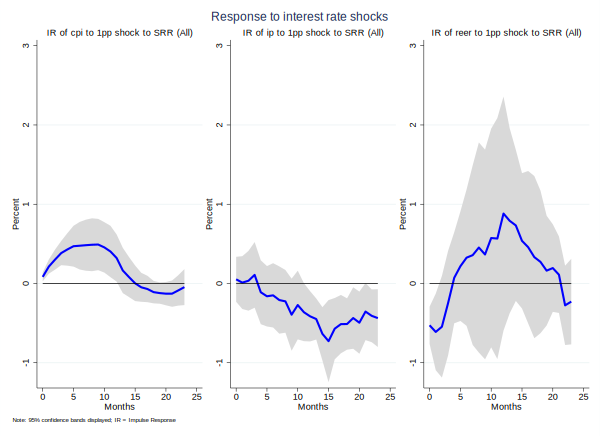




(file /Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empirics/Plots/LP_m
> acro_res_to_srr_shocks.png written in PNG format)


In [20]:
// Plotting effect of CPI to SRR shocks
qui twoway ///
(rarea u_cpi_srr d_cpi_srr horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_cpi_srr horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of cpi to 1pp shock to SRR (All)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_cpi_srr, replace


// Plotting effect of IP to SRR shocks
qui twoway ///
(rarea u_ip_srr d_ip_srr horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_ip_srr horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of ip to 1pp shock to SRR (All)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_ip_srr, replace

// Plotting effect of REER to SRR shocks
qui twoway ///
(rarea u_reer_srr d_reer_srr horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_reer_srr horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of reer to 1pp shock to SRR (All)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_reer_srr, replace


// Combining the graphs
gr combine fig_cpi_srr fig_ip_srr fig_reer_srr, ///
col(3) ycommon ///
imargin(tiny) ///
graphregion(color(white)) plotregion(color(white)) ///
iscale(*0.8) ///
title("Response to interest rate shocks", size(small)) ///
note("Note: 95% confidence bands displayed; IR = Impulse Response" ,size(tiny))

/* Save the combined graph to a file */
graph export "$folder/Plots/LP_macro_res_to_srr_shocks.png", width(2600) height(1300)  replace 


#### 2. Effect of interest rate shocks on Macro variables on High vs Low POLCON Environment

I define the low/high POLCON based on H2/L2 variable.

**Low POLCON**

In [11]:
* Running sxr inflation on lags of Food and ip Inflation for Low POLCON
eststo clear
qui cap drop b_cpi_srr_L2 u_cpi_srr_L2 d_cpi_srr_L2 b_ip_srr_L2 u_ip_srr_L2 d_ip_srr_L2 b_reer_srr_L2 u_reer_srr_L2 d_reer_srr_L2

* Initializing variables to store the regression output
// qui gen horizons = _n-1 if _n <= `hmax'
// qui gen Zero = 0 if _n <= `hmax'
qui gen b_cpi_srr_L2 = .
qui gen u_cpi_srr_L2 = .
qui gen d_cpi_srr_L2 = .
qui gen b_ip_srr_L2 = .
qui gen u_ip_srr_L2 = .
qui gen d_ip_srr_L2 = .
qui gen b_reer_srr_L2 = .
qui gen u_reer_srr_L2 = .
qui gen d_reer_srr_L2 = .

forv h = 0/`hmax'{
    
    ** Regression 1
    * on inflation
    qui reghdfe cpi_yoy_`h' l(0/`ma').srr l(1/`ar').cpi_yoy if dumL2 == 1 , absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the Food Coefficient results
    qui replace b_cpi_srr_L2 = _b[srr]  if _n == `h'+1
    qui replace u_cpi_srr_L2 = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_cpi_srr_L2 = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
 
}

forv h = 0/`hmax'{
    ** Regression 2
    * on ip
    qui reghdfe ip_yoy_`h' l(0/`ma').srr l(1/`ar').ip_yoy if dumL2 == 1, absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the ip Coefficient Reults
    qui replace b_ip_srr_L2 = _b[srr]  if _n == `h'+1
    qui replace u_ip_srr_L2 = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_ip_srr_L2 = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
}

forv h = 0/`hmax'{
    ** Regression 3
    * on reer
    qui reghdfe reer_yoy_`h' l(0/`ma').srr l(1/`ar').reer_yoy if dumL2 == 1, absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the reer Coefficient Reults
    qui replace b_reer_srr_L2 = _b[srr]  if _n == `h'+1
    qui replace u_reer_srr_L2 = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_reer_srr_L2 = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
}

In [13]:
// Saving the regression output
esttab using "$folder/regression/effect_of_srr_on_macro_vars_L2.html", html replace

(note: file /Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empirics/regr
> ession/effect_of_srr_on_macro_vars_L2.html not found)
(output written to /Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empiri
> cs/regression/effect_of_srr_on_macro_vars_L2.html)


**High POLCON**

In [14]:
* Running sxr inflation on lags of Food and ip Inflation for High POLCON
eststo clear
qui cap drop b_cpi_srr_H2 u_cpi_srr_H2 d_cpi_srr_H2 b_ip_srr_H2 u_ip_srr_H2 d_ip_srr_H2 b_reer_srr_H2 u_reer_srr_H2 d_reer_srr_H2

* Initializing variables to store the regression output
// qui gen horizons = _n-1 if _n <= `hmax'
// qui gen Zero = 0 if _n <= `hmax'
qui gen b_cpi_srr_H2 = .
qui gen u_cpi_srr_H2 = .
qui gen d_cpi_srr_H2 = .
qui gen b_ip_srr_H2 = .
qui gen u_ip_srr_H2 = .
qui gen d_ip_srr_H2 = .
qui gen b_reer_srr_H2 = .
qui gen u_reer_srr_H2 = .
qui gen d_reer_srr_H2 = .

forv h = 0/`hmax'{
    
    ** Regression 1
    * on inflation
    qui reghdfe cpi_yoy_`h' l(0/`ma').srr l(1/`ar').cpi_yoy if dumH2 == 1 , absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the Food Coefficient results
    qui replace b_cpi_srr_H2 = _b[srr]  if _n == `h'+1
    qui replace u_cpi_srr_H2 = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_cpi_srr_H2 = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
 
}

forv h = 0/`hmax'{
    ** Regression 2
    * on ip
    qui reghdfe ip_yoy_`h' l(0/`ma').srr l(1/`ar').ip_yoy if dumH2 == 1, absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the ip Coefficient Reults
    qui replace b_ip_srr_H2 = _b[srr]  if _n == `h'+1
    qui replace u_ip_srr_H2 = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_ip_srr_H2 = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
}

forv h = 0/`hmax'{
    ** Regression 3
    * on reer
    qui reghdfe reer_yoy_`h' l(0/`ma').srr l(1/`ar').reer_yoy if dumH2 == 1, absorb(country_code2 mdate) cluster(country_code2)
    
    // Saving the reer Coefficient Reults
    qui replace b_reer_srr_H2 = _b[srr]  if _n == `h'+1
    qui replace u_reer_srr_H2 = _b[srr] + 1.96*_se[srr] if _n == `h'+1
    qui replace d_reer_srr_H2 = _b[srr] - 1.96*_se[srr] if _n == `h'+1
    qui eststo
}

In [15]:
// Saving the regression output
esttab using "$folder/regression/effect_of_srr_on_macro_vars_H2.html", html replace

(note: file /Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empirics/regr
> ession/effect_of_srr_on_macro_vars_H2.html not found)
(output written to /Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empiri
> cs/regression/effect_of_srr_on_macro_vars_H2.html)


Plotting the three results together - 1. Low Polcon 2. High Polcon and 3. All

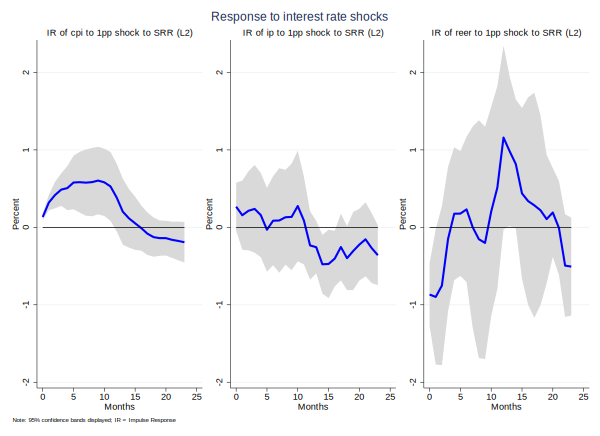

In [24]:
// Graphs for effect due to interest rate shocks in Low POLCON Regime

// Plotting effect of CPI to SRR shocks
qui twoway ///
(rarea u_cpi_srr_L2 d_cpi_srr_L2 horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_cpi_srr_L2 horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of cpi to 1pp shock to SRR (L2)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_cpi_srr_L2, replace


// Plotting effect of IP to SRR shocks
qui twoway ///
(rarea u_ip_srr_L2 d_ip_srr_L2 horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_ip_srr_L2 horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of ip to 1pp shock to SRR (L2)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_ip_srr_L2, replace

// Plotting effect of REER to SRR shocks
qui twoway ///
(rarea u_reer_srr_L2 d_reer_srr_L2 horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_reer_srr_L2 horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of reer to 1pp shock to SRR (L2)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_reer_srr_L2, replace


// Combining the graphs
gr combine fig_cpi_srr_L2 fig_ip_srr_L2 fig_reer_srr_L2, ///
col(3) ycommon ///
imargin(tiny) ///
graphregion(color(white)) plotregion(color(white)) ///
iscale(*0.8) ///
title("Response to interest rate shocks", size(small)) ///
note("Note: 95% confidence bands displayed; IR = Impulse Response" ,size(tiny))

/* Save the combined graph to a file */
// graph export "$folder/Plots/LP_macro_res_to_srr_L2_shocks.png", width(2600) height(1300)  replace 



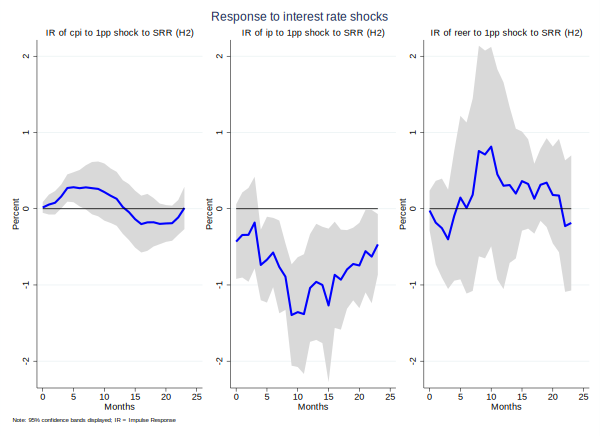

In [25]:
// Graphs for effect due to interest rate shocks in High POLCON Regime

// Plotting effect of CPI to SRR shocks
qui twoway ///
(rarea u_cpi_srr_H2 d_cpi_srr_H2 horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_cpi_srr_H2 horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of cpi to 1pp shock to SRR (H2)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_cpi_srr_H2, replace


// Plotting effect of IP to SRR shocks
qui twoway ///
(rarea u_ip_srr_H2 d_ip_srr_H2 horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_ip_srr_H2 horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of ip to 1pp shock to SRR (H2)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_ip_srr_H2, replace

// Plotting effect of REER to SRR shocks
qui twoway ///
(rarea u_reer_srr_H2 d_reer_srr_H2 horizons,  ///
fcolor(gs13) lcolor(gs13) lw(none) lpattern(solid)) ///
(line b_reer_srr_H2 horizons, lcolor(blue) ///
lpattern(solid) lwidth(thick)) ///
(line Zero horizons, lcolor(black)), legend(off) ///
title("IR of reer to 1pp shock to SRR (H2)", color(black) size(medsmall)) ///
ytitle("Percent", size(medsmall)) xtitle("Months", size(medsmall)) ///
graphregion(color(white)) plotregion(color(white))
gr rename fig_reer_srr_H2, replace


// Combining the graphs
gr combine fig_cpi_srr_H2 fig_ip_srr_H2 fig_reer_srr_H2, ///
col(3) ycommon ///
imargin(tiny) ///
graphregion(color(white)) plotregion(color(white)) ///
iscale(*0.8) ///
title("Response to interest rate shocks", size(small)) ///
note("Note: 95% confidence bands displayed; IR = Impulse Response" ,size(tiny))

/* Save the combined graph to a file */
// graph export "$folder/Plots/LP_macro_res_to_srr_H2_shocks.png", width(2600) height(1300)  replace 



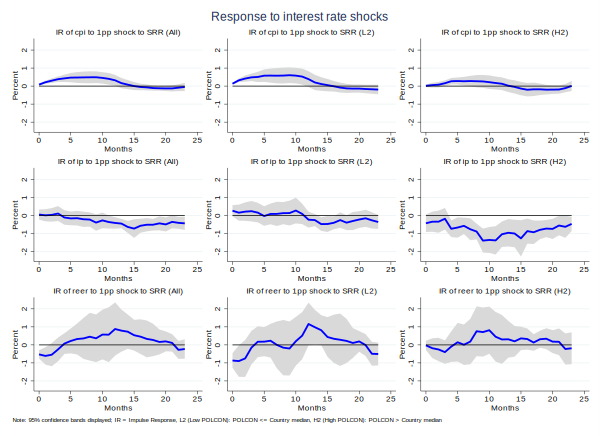




(file /Users/suraj/Dropbox/Chatterjee_Mitra_Fiscal_Dominance/Empirics/Plots/LP_m
> acro_res_to_srr_shocks_all_L2_H2.png written in PNG format)


In [30]:
// Plotting all the charts together

// Combining the graphs
gr combine fig_cpi_srr fig_cpi_srr_L2 fig_cpi_srr_H2 fig_ip_srr fig_ip_srr_L2 fig_ip_srr_H2 fig_reer_srr fig_reer_srr_L2 fig_reer_srr_H2, ///
col(3) ycommon ///
imargin(tiny) ///
graphregion(color(white)) plotregion(color(white)) ///
iscale(*0.8) ///
title("Response to interest rate shocks", size(small)) ///
note("Note: 95% confidence bands displayed; IR = Impulse Response, L2 (Low POLCON): POLCON <= Country median, H2 (High POLCON): POLCON > Country median" ,size(tiny))

/* Save the combined graph to a file */
graph export "$folder/Plots/LP_macro_res_to_srr_shocks_all_L2_H2.png", width(2600) height(1600)  replace 